In [1]:
%cd '/content/drive/MyDrive/Meta_learning_research/Notebooks/'
from data_util import *

/content/drive/MyDrive/Meta_learning_research/Notebooks


In [2]:
%cd '/content/drive/MyDrive/Meta_learning_research/Notebooks/'
data_dir = './samples/'  # Replace with the path to your directory containing numpy files
locations_meta_training = ['Alexander', 'Rowancreek']
locations_meta_testing = ['Covington']
num_samples_per_location = 10  # Configure the number of samples per location
num_episodes = 10  # Number of episodes

data_loader = MetaDataLoader(data_dir, num_samples_per_location)

# Create multi episodes for meta-training
mate_train_episodes = data_loader.create_multi_episodes(num_episodes, locations_meta_training)
mate_test_episodes = data_loader.create_multi_episodes(num_episodes, locations_meta_testing)

/content/drive/MyDrive/Meta_learning_research/Notebooks


In [3]:
mate_train_episodes[0]['support_set_data'].shape

(20, 224, 224, 8)

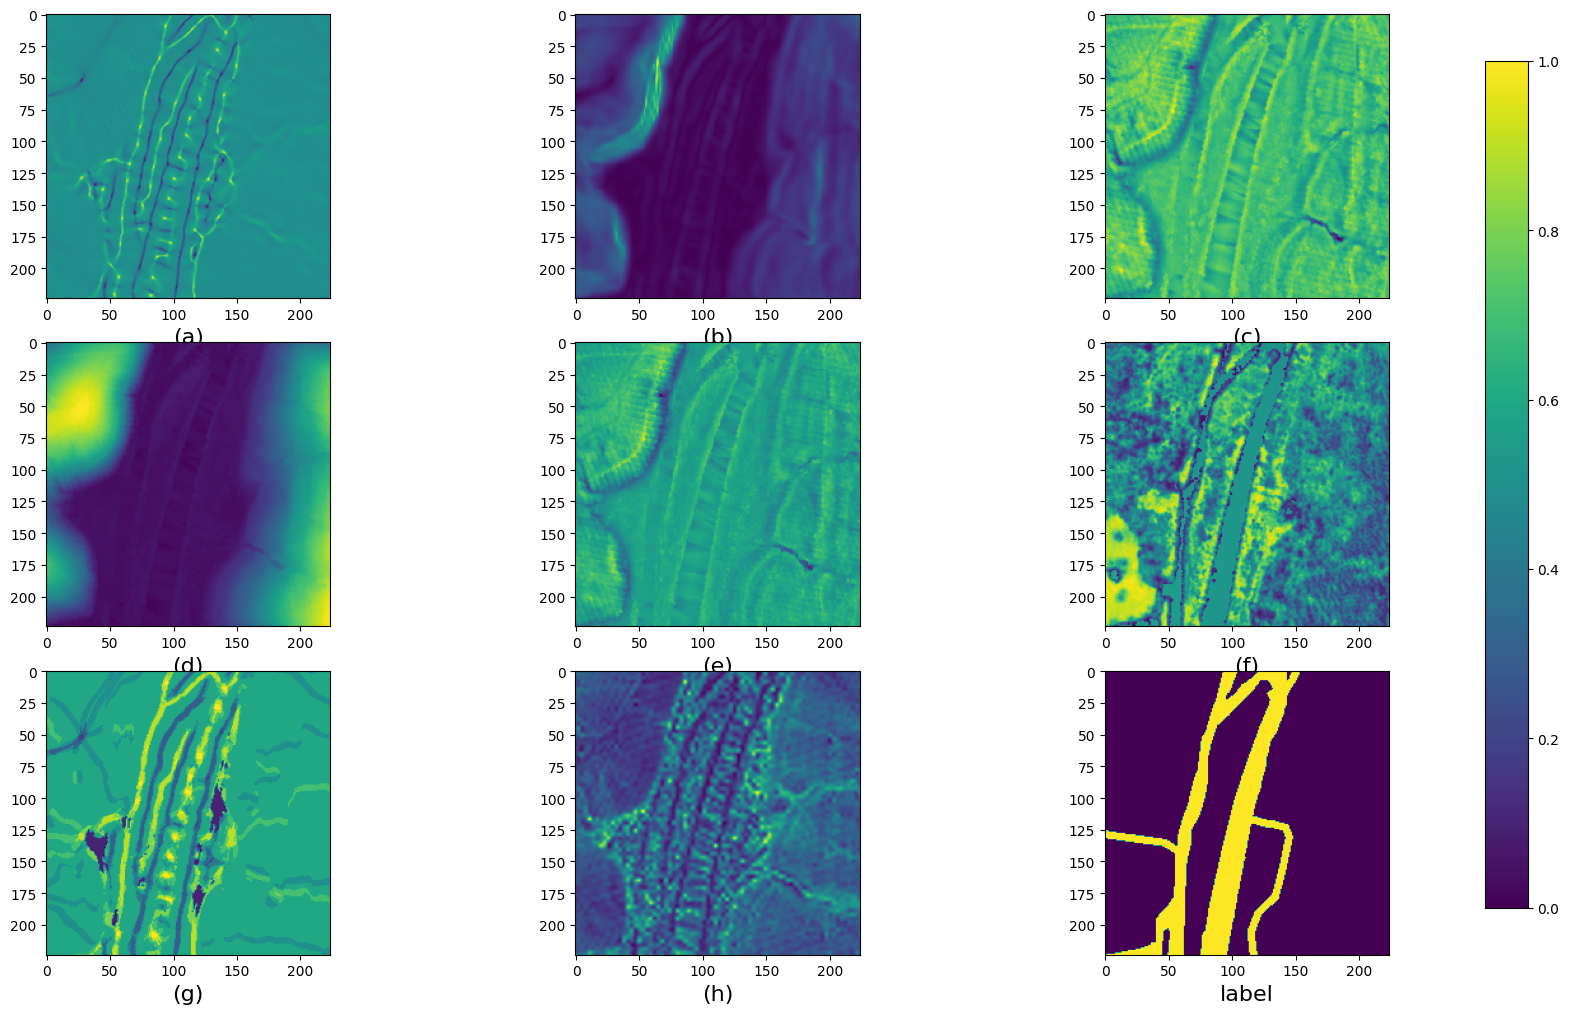

In [13]:
import numpy as np
import matplotlib.pyplot as plt
rando_ind = 19
fig, axs = plt.subplots(3, 3,figsize=(20,10))
fig.tight_layout()
labels = ["a","b","c","d","e","f","g","h"]
count = 0
img_order = [0,1,2,3,4,5,6,7]
for ax in axs.flat:

  if count == 8:
    im = ax.imshow(mate_train_episodes[0]['support_set_labels'][rando_ind][:,:,0])
    ax.set_xlabel("label", fontsize = 16)
  else:
    image = mate_train_episodes[0]['support_set_data'][rando_ind,:,:,img_order[count]]
    im = ax.imshow(image)
    ax.set_xlabel("("+labels[count]+")", fontsize = 16)

  count = count + 1

fig.colorbar(im, ax=axs.ravel().tolist() , shrink=0.9)
plt.show()

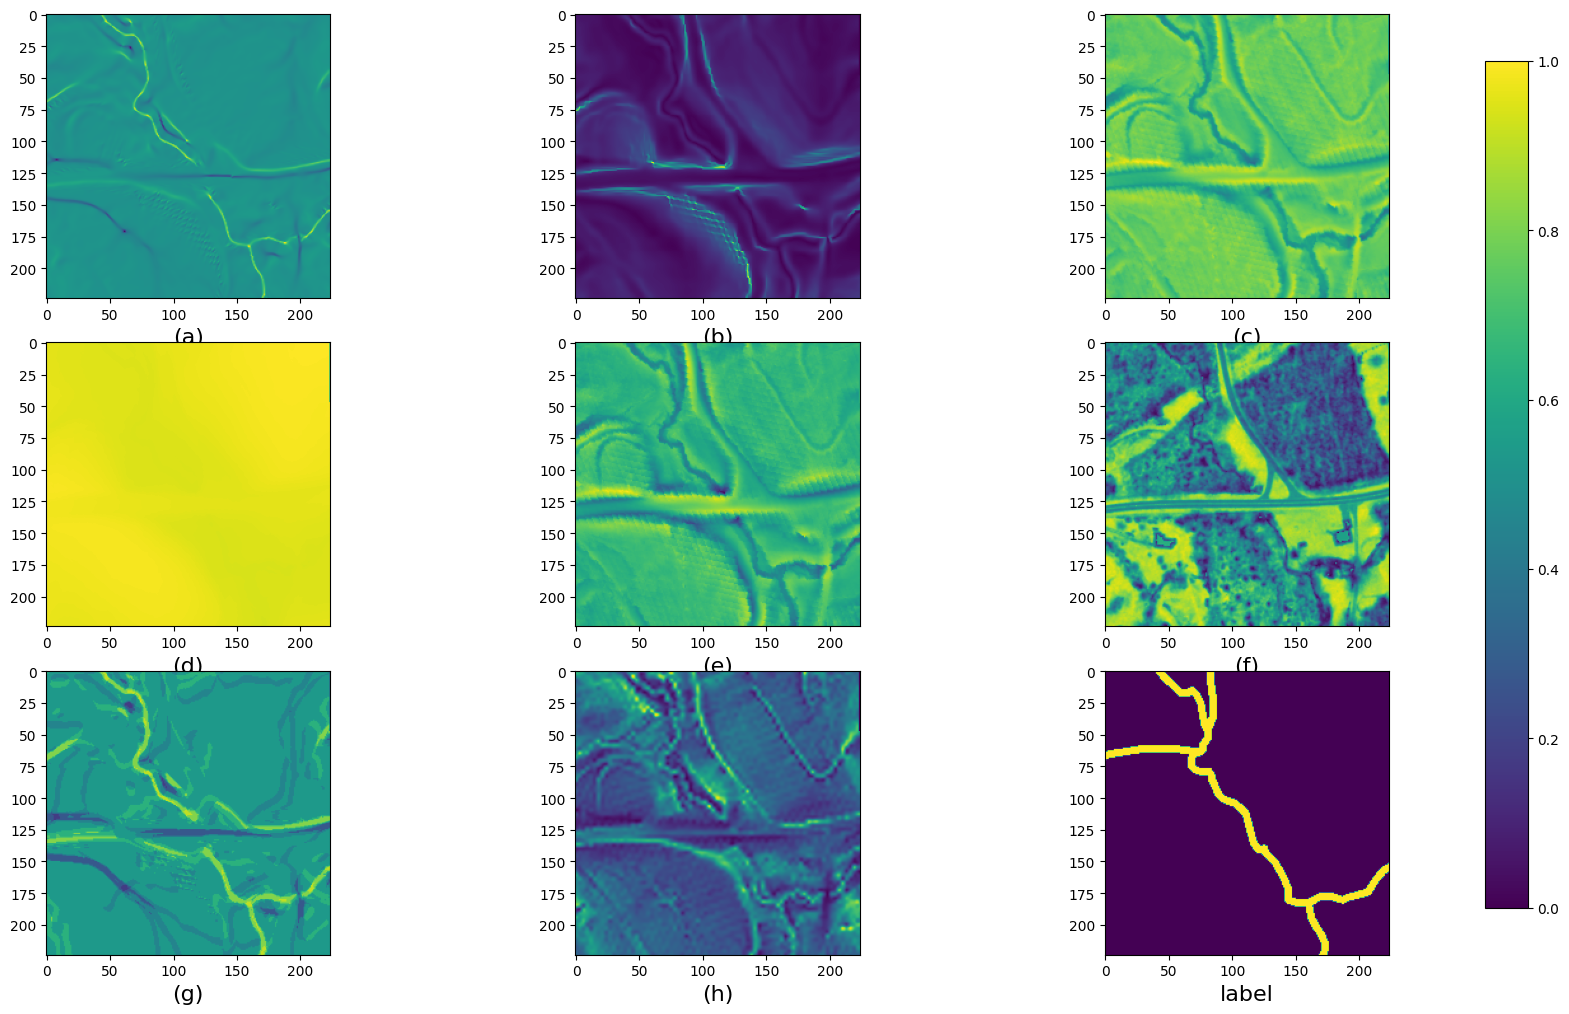

In [28]:
rando_ind = 15
fig, axs = plt.subplots(3, 3,figsize=(20,10))
fig.tight_layout()
labels = ["a","b","c","d","e","f","g","h"]
count = 0
img_order = [0,1,2,3,4,5,6,7]
for ax in axs.flat:

  if count == 8:
    im = ax.imshow(mate_train_episodes[0]['query_set_labels'][rando_ind][:,:,0])
    ax.set_xlabel("label", fontsize = 16)
  else:
    image = mate_train_episodes[0]['query_set_data'][rando_ind,:,:,img_order[count]]
    im = ax.imshow(image)
    ax.set_xlabel("("+labels[count]+")", fontsize = 16)

  count = count + 1

fig.colorbar(im, ax=axs.ravel().tolist() , shrink=0.9)
plt.show()

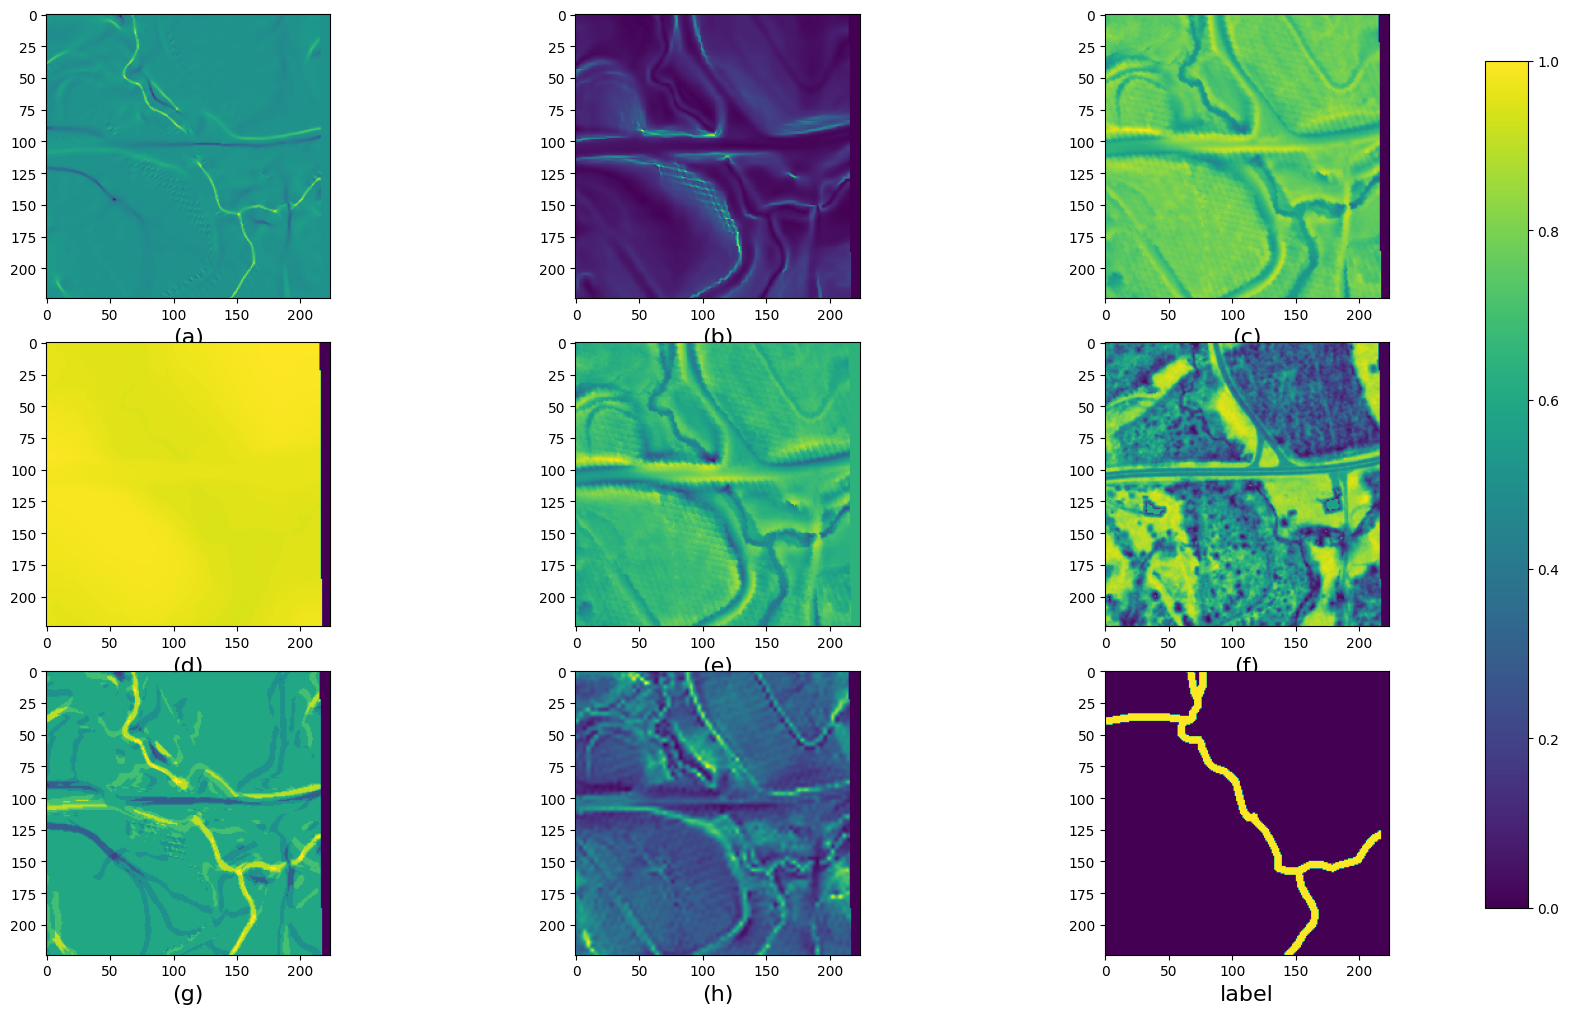

In [29]:
rando_ind = 14
fig, axs = plt.subplots(3, 3,figsize=(20,10))
fig.tight_layout()
labels = ["a","b","c","d","e","f","g","h"]
count = 0
img_order = [0,1,2,3,4,5,6,7]
for ax in axs.flat:

  if count == 8:
    im = ax.imshow(mate_train_episodes[0]['query_set_labels'][rando_ind][:,:,0])
    ax.set_xlabel("label", fontsize = 16)
  else:
    image = mate_train_episodes[0]['query_set_data'][rando_ind,:,:,img_order[count]]
    im = ax.imshow(image)
    ax.set_xlabel("("+labels[count]+")", fontsize = 16)

  count = count + 1

fig.colorbar(im, ax=axs.ravel().tolist() , shrink=0.9)
plt.show()

In [4]:
import os
import numpy as np
import tensorflow as tf

class MetaDataLoader:
    def __init__(self, data_dir, num_samples_per_location=100):
        self.data_dir = data_dir
        self.num_samples_per_location = num_samples_per_location

    def _load_and_process_data(self, locations):
        data_dict = {}

        for location in locations:
            location_dir = os.path.join(self.data_dir, location)

            train_data_path = os.path.join(location_dir, "train_data.npy")
            train_label_path = os.path.join(location_dir, "train_label.npy")
            vali_data_path = os.path.join(location_dir, "vali_data.npy")
            vali_label_path = os.path.join(location_dir, "vali_label.npy")

            # Load training data and labels
            train_data = np.load(train_data_path)
            train_label = np.load(train_label_path)

            # Load validation data and labels
            vali_data = np.load(vali_data_path)
            vali_label = np.load(vali_label_path)

            # Store data and labels in the data_dict with location as key
            data_dict[location] = {
                'train_data': train_data,
                'train_label': train_label,
                'vali_data': vali_data,
                'vali_label': vali_label
            }

        return data_dict

    def _create_episode(self, locations):

        data_dict = self._load_and_process_data(locations)


        #--------- Create the support set -------------
        selected_data = []
        selected_labels = []

        for location in locations:
          # Initialize temporary lists
          temp_data = []
          temp_labels = []

          # Iterate over samples in the location's training data
          for data, label in zip(data_dict[location]['train_data'], data_dict[location]['train_label']):
              if np.sum(label == 1) > 500:  # Check if label has more than 500 pixels of class 1
                  temp_data.append(data)
                  temp_labels.append(label)

          # Ensure you have enough samples
          if len(temp_data) >= self.num_samples_per_location:
              selected_data.extend(temp_data[:self.num_samples_per_location])
              selected_labels.extend(temp_labels[:self.num_samples_per_location])
          else:
              # Handle cases where not enough samples meet the criteria in the location
              print(f"Warning: Not enough samples with >500 pixels of class 1 in location for support set in {location}")


        data = np.array(selected_data)
        labels = np.array(selected_labels)

        # Shuffle the data and labels if needed
        indices = np.arange(data.shape[0])
        np.random.shuffle(indices)
        support_set_data = data[indices]
        support_set_labels = labels[indices]

        #--------- End create the support set -------------

        #--------- Create the query set -------------
        selected_data = []
        selected_labels = []

        for location in locations:
          # Initialize temporary lists
          temp_data = []
          temp_labels = []

          # Iterate over samples in the location's training data
          for data, label in zip(data_dict[location]['vali_data'], data_dict[location]['vali_label']):
              if np.sum(label == 1) > 500:  # Check if label has more than 500 pixels of class 1
                  temp_data.append(data)
                  temp_labels.append(label)

          # Ensure you have enough samples
          if len(temp_data) >= self.num_samples_per_location:
              selected_data.extend(temp_data[:self.num_samples_per_location])
              selected_labels.extend(temp_labels[:self.num_samples_per_location])
          else:
              # Handle cases where not enough samples meet the criteria in the location
              print(f"Warning: Not enough samples with >500 pixels of class 1 in location for query set in {location}")

        data = np.array(selected_data)
        labels = np.array(selected_labels)

        # Shuffle the data and labels if needed
        indices = np.arange(data.shape[0])
        np.random.shuffle(indices)
        query_set_data = data[indices]
        query_set_labels = labels[indices]

        #--------- End create the query set -------------

        return support_set_data, support_set_labels, query_set_data, query_set_labels

    def create_multi_episodes(self, num_episodes, locations):
        episodes = []
        for _ in range(num_episodes):
            support_set_data, support_set_labels, query_set_data, query_set_labels = self._create_episode(locations)
            episode = {
                "support_set_data": support_set_data,
                "support_set_labels": support_set_labels,
                "query_set_data": query_set_data,
                "query_set_labels": query_set_labels
            }
            episodes.append(episode)
        return episodes